# Problem statement


**Question to be resolved**



How effectively can we identify borrowers who are likely to default on a loan (Default = 1) using demographic, financial, and loan-related information, while minimizing the risk of misclassifying high-risk borrowers as low risk?


**Context**

The objective of this project is to **predict whether a customer will default on a loan (binary outcome) based on demographic, financial, and loan-related characteristics**. Credit default risk assessment is a central challenge for banks and financial institutions, as loan defaults directly affect profitability, capital adequacy, and overall financial stability. Accurate default prediction supports better credit approval decisions, risk-based pricing, and effective portfolio risk management.

This study addresses a binary classification problem using a real-world dataset sourced from Kaggle, where borrowers are classified as defaulting (Default = 1) or non-defaulting (Default = 0). A key challenge in this setting is the asymmetric cost of classification errors: **misclassifying a defaulter as a non-defaulter (false negative) is significantly more costly than incorrectly flagging a reliable borrower as high risk (false positive)**. Consequently, the primary objective is to identify as many defaulting borrowers as possible, even at the expense of a higher false-positive rate.

To reflect this priority, model **evaluation focuses on recall for the default class, with the F2-score used as the main model selection criterion**, as it places greater weight on recall than precision and aligns with real-world credit risk management objectives.

#Solution approach

Multiple supervised classification models are implemented and compared:

*   Logistic Regression (L2 regularization)

*   Logistic Regression (Elastic Net regularization)

*   Decision Tree

*   Random Forest

*   Linear Support Vector Machine (SVM)

Logistic regression is included as a baseline and benchmark model, as it is widely used by financial institutions due to its interpretability, stability, and regulatory acceptance. Regularization techniques (L2 and Elastic Net) are applied to control overfitting and handle potential multicollinearity among predictors.

Tree-based models (Decision Tree and Random Forest) are implemented to capture potential non-linear relationships and feature interactions that linear models may miss. A linear SVM is included as an alternative margin-based classifier for comparison.

Although more complex models may offer additional flexibility, **it is anticipated that regularized logistic regression will perform relatively better than the other models and it remains the most widely used approach in credit default modeling**, given the  nature of the data and aim of the project. The remaining models are implemented primarily for performance comparison and robustness checks.

**Evaluation critera**

Given the class imbalance in the dataset and the asymmetric cost of misclassification, model performance during cross-validation is assessed using the Precision–Recall Area Under the Curve (PR AUC). Final model selection is based on the F2-score evaluated on held-out test data, as this metric places greater emphasis on recall than precision and directly reflects the project’s objective of minimizing false negatives.

#Data Description and Variables

* LoanID: Unique identifier for each loan record (not used as a predictive feature).

Target variable

* Default: Target label indicating whether the borrower defaulted.( 1 = default, 0 = no default)

**Numerical predictors**

* Age: Borrower’s age (years).

* Income: Borrower’s income (currency units per year, depending on dataset).

* LoanAmount: Amount of money borrowed.

* CreditScore: Credit score (higher usually means lower risk).

* MonthsEmployed: Number of months the borrower has been employed.

* NumCreditLines: Number of active credit lines.

* InterestRate: Interest rate applied to the loan (%).

* LoanTerm: Loan duration (often in months).

* DTIRatio: Debt-to-income ratio (share of income used to service debt; higher often means higher risk).

**Categorical predictors**

* Education: Education level (High School, Bachelor’s, Master’s, PhD).

* EmploymentType: Employment status/type (Full-time, Part-time, Self-employed, Unemployed).

* MaritalStatus: Marital status (Single, Married, Divorced).

* HasMortgage: Whether the borrower currently has a mortgage (Yes/No).

* HasDependents: Whether the borrower has dependents (Yes/No).

* LoanPurpose: Purpose of the loan (Auto, Home, Business, Education, Other).

* HasCoSigner: Whether the loan has a co-signer (Yes/No).


Source: https://www.kaggle.com/datasets/nikhil1e9/loan-default

#Exploratory Data Analysis (EDA)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Loan_default.csv to Loan_default.csv


In [3]:
df = pd.read_csv("Loan_default.csv")

In [4]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [6]:
target = "Default"

X = df.drop(columns=[target, "LoanID"])
y = df[target]

numeric_features = ["Age", "Income", "LoanAmount", "CreditScore",
    "MonthsEmployed", "NumCreditLines",
    "InterestRate", "LoanTerm", "DTIRatio"]


categorical_features = [ "Education", "EmploymentType", "MaritalStatus",
    "HasMortgage", "HasDependents", "LoanPurpose", "HasCoSigner"]


In [7]:
# 2. Exploratory Data Analysis (EDA)|

In [8]:
# 2.1. Target distribution
y.value_counts()


,count
Default,
0,225694
1,29653


In [9]:
y.value_counts(normalize=True)

,proportion
Default,
0,0.883872
1,0.116128


The target is imbalanced (≈11.6% defaults). Therefore, we use stratified splits and focus on imbalance-robust metrics (Balanced Accuracy, F2, PR-AUC) and later tune the decision threshold instead of relying on the default 0.5.

In [10]:
# 2.2 Summary statistics for numeric features
numeric_features = ["Age", "Income", "LoanAmount", "CreditScore",
    "MonthsEmployed", "NumCreditLines",
    "InterestRate", "LoanTerm", "DTIRatio"]
df[numeric_features].describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000


Summary statistics confirm plausible ranges (e.g., Age 18–69, CreditScore 300–849, DTI in [0.1, 0.9]) and no obvious invalid values in numeric features.

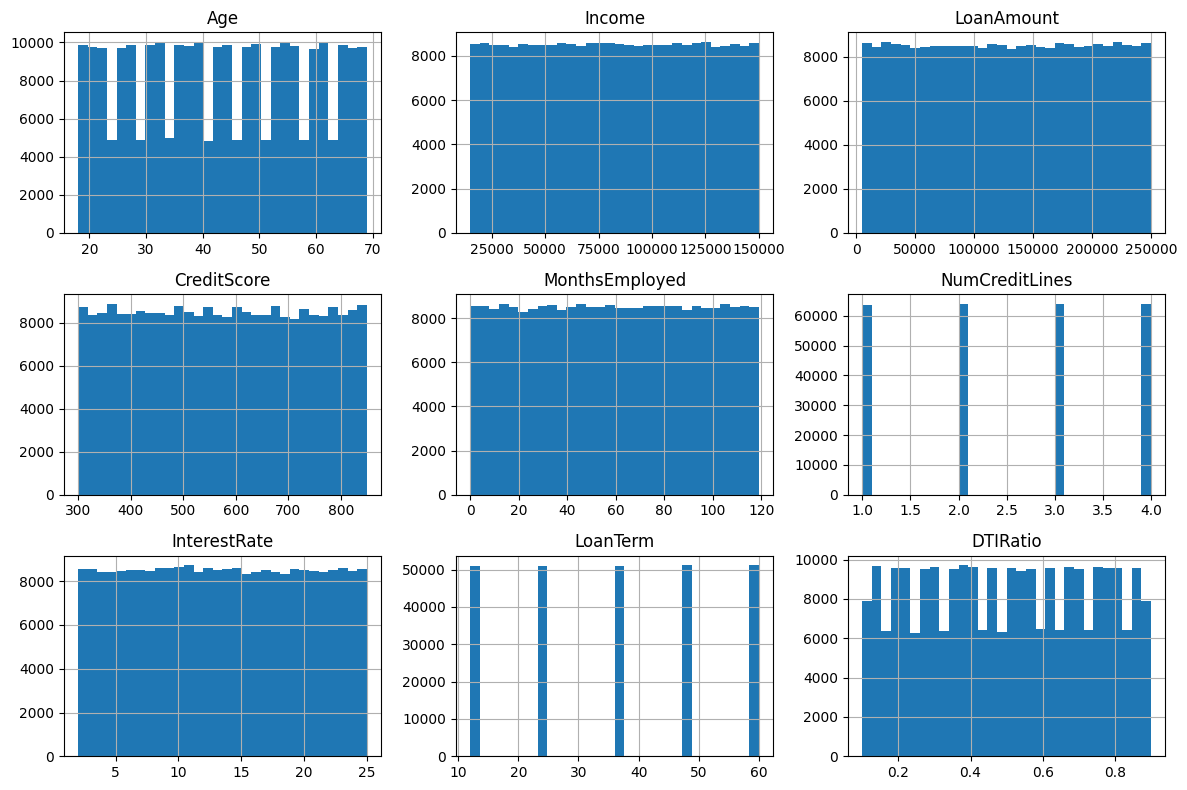

In [11]:
import matplotlib.pyplot as plt

# 2.3 Histograms for numeric variables
df[numeric_features].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()



Numeric features appear broadly well-spread across their ranges (close to uniform for many variables), suggesting limited skewness. For linear models we still apply standardization, while tree-based models should work without additional transformations.

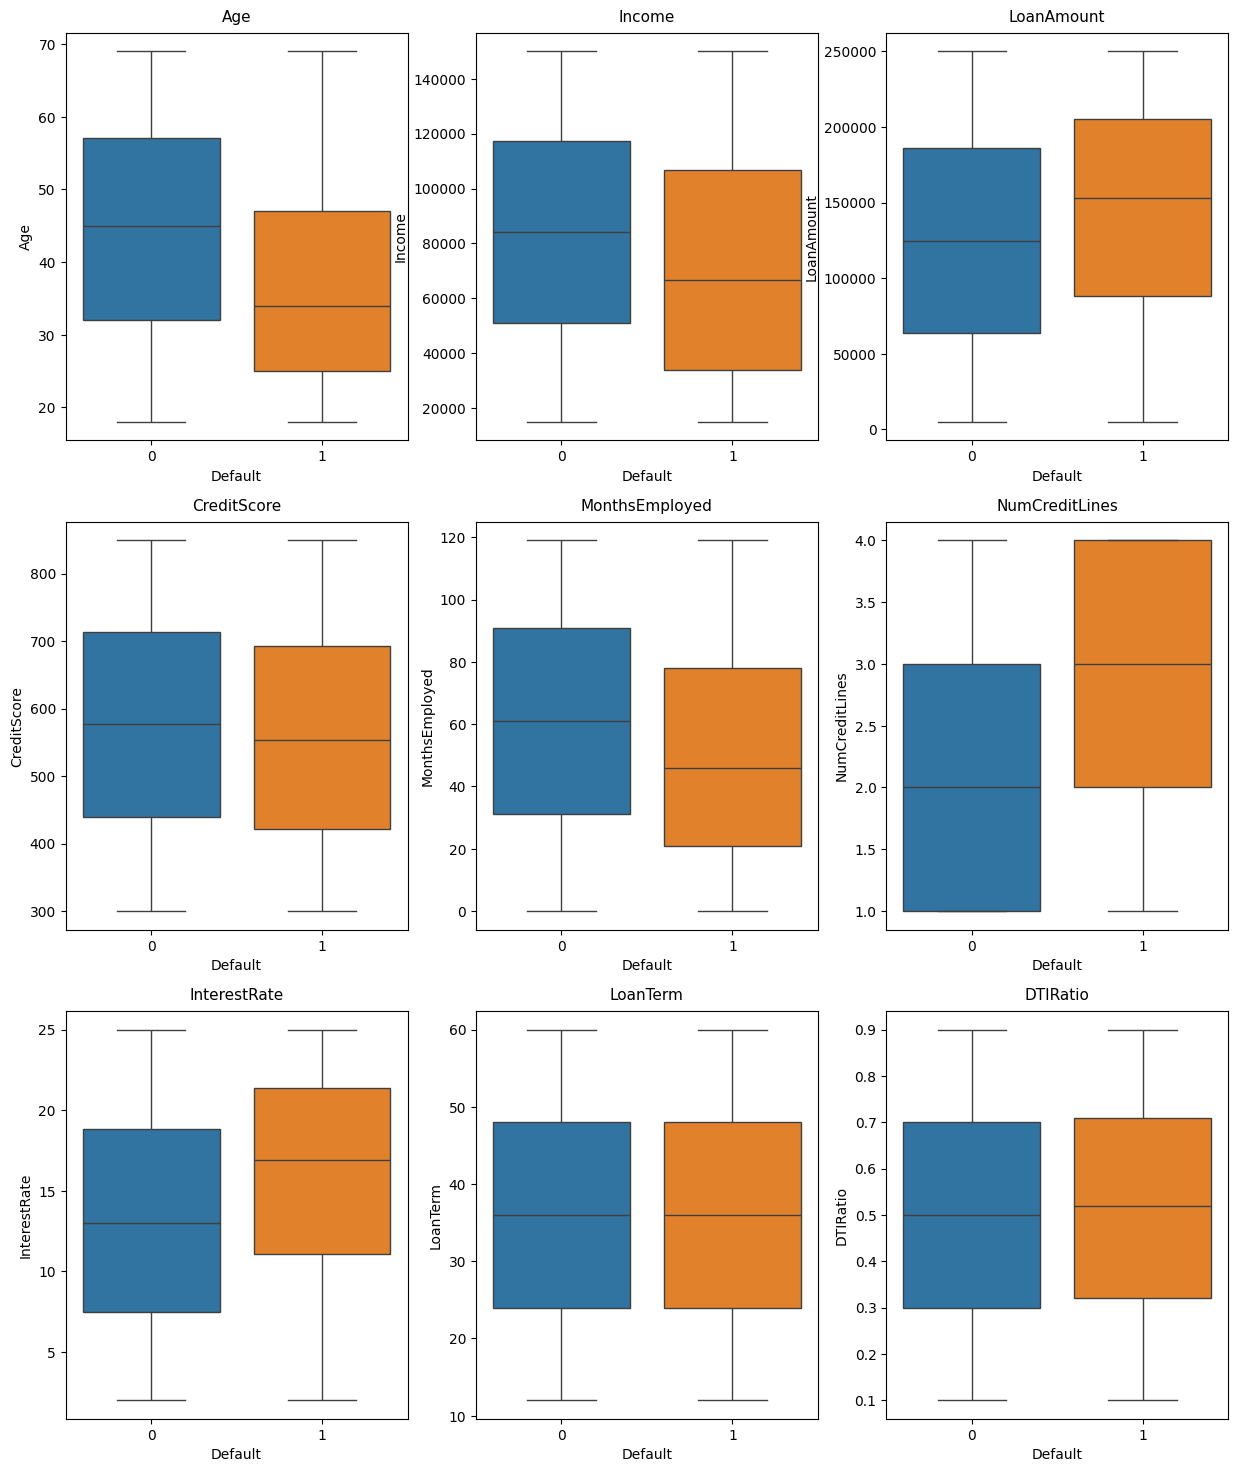

In [12]:

# Boxplots for continuous features
n_cols = 3
n_rows = math.ceil(len(numeric_features) / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(15, 6 * n_rows)
)
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.boxplot(
        data=df,
        x=target,
        y=col,
        hue=target,
        palette=["tab:blue", "tab:orange"],
        dodge=False,
        ax=axes[i],
        showfliers=False
    )
    axes[i].set_title(col, fontsize=11, pad=8)
    axes[i].set_xlabel("Default")
    axes[i].legend([], [], frameon=False)

From the boxplots we observe class separation for several features:

- defaults tend to have lower CreditScore,
- shorter MonthsEmployed,
- differences are also visible for NumCreditLines / DTI (we keep all features and let regularization / trees decide final importance).

In [13]:
# 2.4 Categorical variables distributions

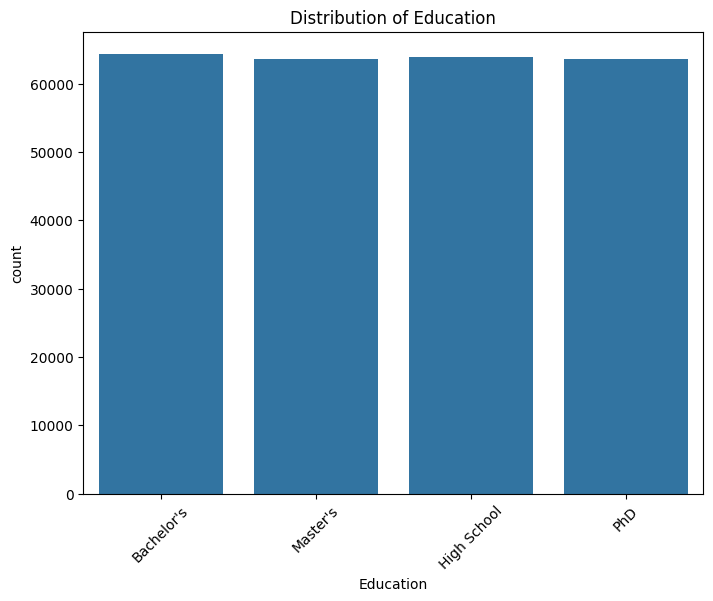

In [14]:
# Distribution of "Education"
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Education')
plt.xticks(rotation=45)
plt.title('Distribution of Education')
plt.show()

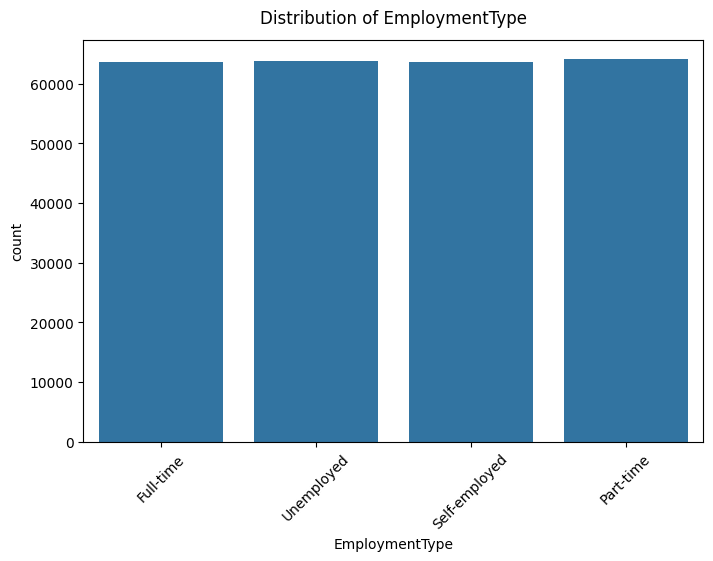

In [15]:
# Distribution of "EmploymentType"
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(data=df, x="EmploymentType", ax=ax)
ax.tick_params(axis="x", rotation=45)
ax.set_title("Distribution of EmploymentType", pad=12)

fig.subplots_adjust(top=0.92, bottom=0.25)
plt.show()


Categorical variables are reasonably balanced across categories, so we keep them and encode using one-hot encoding (handle_unknown="ignore").

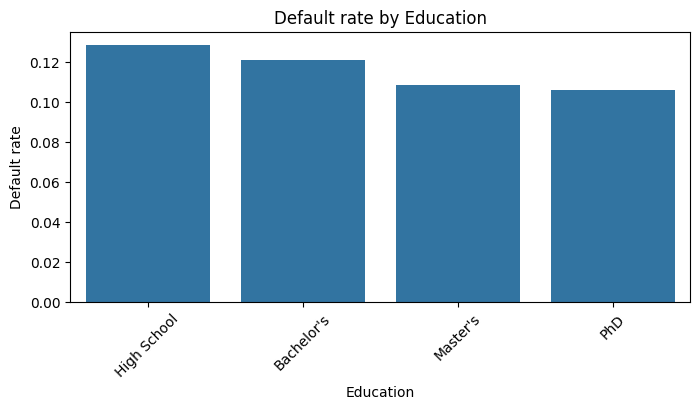

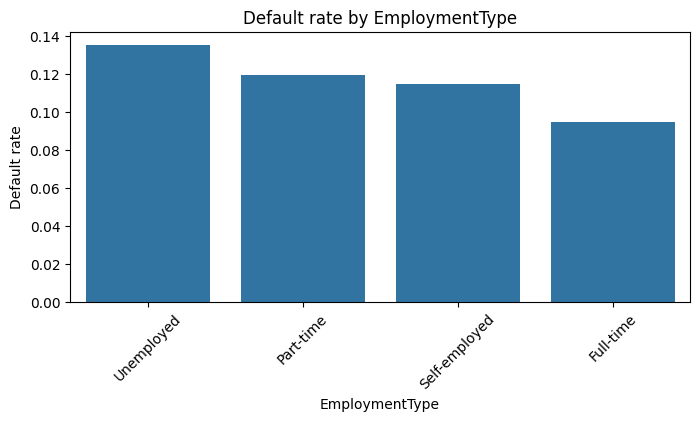

In [16]:
# Default count by categories

def default_rate_plot(df, col, target="Default"):
    rate = (df.groupby(col)[target].mean()
              .sort_values(ascending=False)
              .reset_index(name="default_rate"))

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(data=rate, x=col, y="default_rate", ax=ax)

    ax.set_title(f"Default rate by {col}")
    ax.set_ylabel("Default rate")
    ax.tick_params(axis="x", rotation=45)

    fig.subplots_adjust(top=0.7, bottom=0.25)

    plt.show()

default_rate_plot(df, "Education")
default_rate_plot(df, "EmploymentType")


Because the target is imbalanced, we compare categories using the default rate (mean of the binary target) rather than raw counts. Education shows only small differences in default probability, suggesting a weaker standalone signal. Employment type is more informative: Unemployed and Part-time customers have higher default rates than Full-time, so this variable may contribute to predictive performance after one-hot encoding.

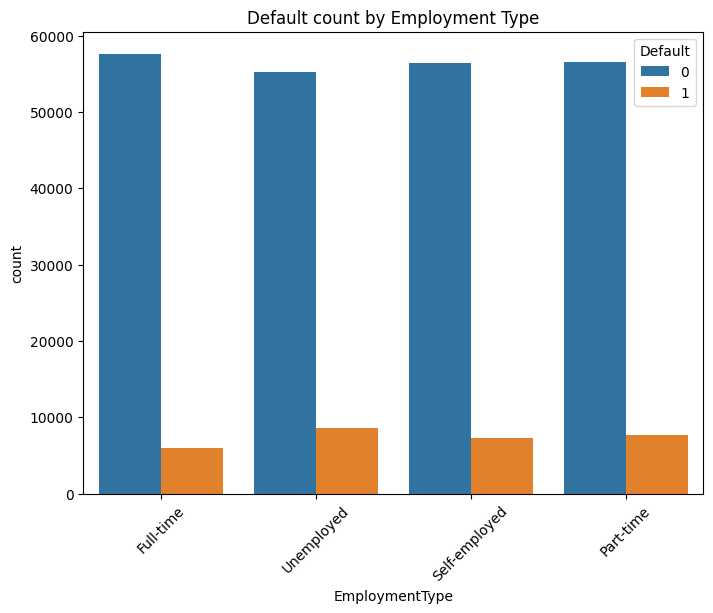

In [17]:
# 2.5.2 Default by EmploymentType
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='EmploymentType', hue='Default')
plt.xticks(rotation=45)
plt.title('Default count by Employment Type')
plt.show()

This plot shows raw counts of defaults and non-defaults across EmploymentType categories. Because the target is imbalanced, counts mainly reflect dataset size; therefore, we also analyse default rate (proportion of defaults) to compare risk between categories more fairly.

In [18]:
# Numeric

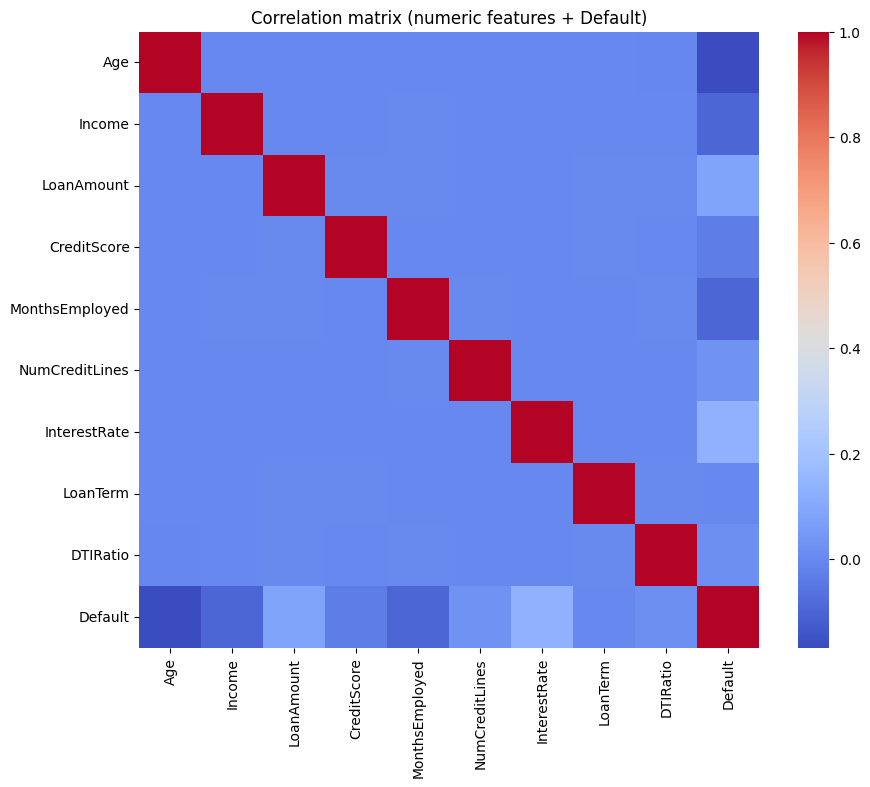

In [19]:
# 2.6 Correlation between numercical variables and target
correlation_matrix = df[numeric_features + [target]].corr()

plt.figure(figsize=(10,8))
sns.heatmap(data=correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation matrix (numeric features + Default)')
plt.show()

The correlation heatmap suggests low to moderate correlations between numeric variables, indicating limited multicollinearity. Correlations with the target (Default) are generally small, which implies that relationships may be weakly linear and could be captured better by non-linear models or interactions.

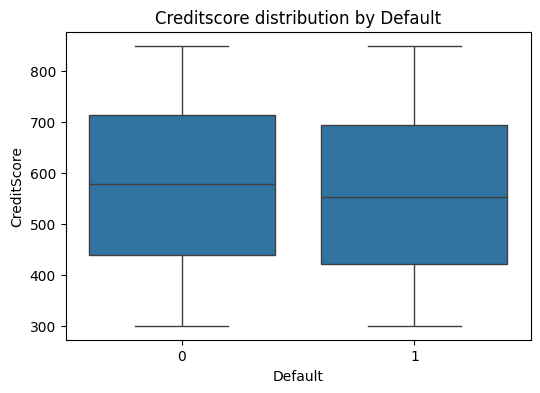

In [20]:
# 2.7 Boxplot of CreditScore by Default

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Default', y='CreditScore')
plt.title('Creditscore distribution by Default')
plt.show()

Defaulters (1) tend to have lower CreditScore than non-defaulters (0). Although the distributions overlap, the shift in median/mean indicates CreditScore is a potentially informative feature for predicting default

In [21]:
df.groupby("Default")["CreditScore"].mean()

,CreditScore
Default,
0,576.232270
1,559.286143


Summary statistics confirm the visual trend: the default group has a lower mean and median CreditScore, consistent with higher risk among borrowers with weaker credit profiles.

In [22]:
# Numeric feature vs Default
# Comparing feature distributions across Default classes

from scipy import stats

feature = "CreditScore"
target = "Default"

x0 = df.loc[df[target] == 0, feature].dropna()
x1 = df.loc[df[target] == 1, feature].dropna()

print("n0, n1:", len(x0), len(x1))
print("mean0, mean1:", x0.mean(), x1.mean())
print("median0, median1:", x0.median(), x1.median())


n0, n1: 225694 29653
mean0, mean1: 576.2322702420091 559.2861430546657
median0, median1: 577.0 553.0


We compare CreditScore distributions between non-default (0) and default (1) borrowers. Lower mean/median CreditScore in the default group indicates a negative relationship with default risk, suggesting CreditScore is a potentially informative feature.



In [23]:
feature = "DTIRatio"
target = "Default"

x0 = df.loc[df[target] == 0, feature].dropna()
x1 = df.loc[df[target] == 1, feature].dropna()

print("n0, n1:", len(x0), len(x1))
print("mean0, mean1:", x0.mean(), x1.mean())
print("median0, median1:", x0.median(), x1.median())

n0, n1: 225694 29653
mean0, mean1: 0.498602000939325 0.5124665295248374
median0, median1: 0.5 0.52


We compare DTIRatio between non-default (0) and default (1) borrowers. The default group shows a slightly higher mean and median DTIRatio, suggesting that higher debt-to-income ratios are associated with increased default risk. Although the difference is modest, it may still be informative when combined with other predictors.

In [24]:
feature = "InterestRate"
target = "Default"

x0 = df.loc[df[target] == 0, feature].dropna()
x1 = df.loc[df[target] == 1, feature].dropna()

print("n0, n1:", len(x0), len(x1))
print("mean0, mean1:", x0.mean(), x1.mean())
print("median0, median1:", x0.median(), x1.median())

n0, n1: 225694 29653
mean0, mean1: 13.176993717156861 15.89622668869929
median0, median1: 12.99 16.93


We compare InterestRate between non-default (0) and default (1) borrowers. The default group has a noticeably higher mean and median interest rate, indicating a positive relationship between interest rate and default risk. This suggests InterestRate is a strong candidate predictor, potentially reflecting risk-based pricing (higher-risk applicants receive higher rates) and/or increased repayment burden.

In [25]:
feature = "Income"
target = "Default"

x0 = df.loc[df[target] == 0, feature].dropna()
x1 = df.loc[df[target] == 1, feature].dropna()

print("n0, n1:", len(x0), len(x1))
print("mean0, mean1:", x0.mean(), x1.mean())
print("median0, median1:", x0.median(), x1.median())

n0, n1: 225694 29653
mean0, mean1: 83899.16599466534 71844.72265875291
median0, median1: 84237.5 66566.0


Default borrowers have lower income (mean and median), indicating income is negatively associated with default risk.

In [26]:
# Welch’s two-sample t-test (Default=0 vs Default=1)

from scipy import stats

feature = "InterestRate"
x0 = df.loc[df["Default"]==0, feature].dropna()
x1 = df.loc[df["Default"]==1, feature].dropna()

t_stat, p_val = stats.ttest_ind(x0, x1, equal_var=False)  # Welch
print("Welch t-test:", feature)
print("t =", t_stat)
print("p =", p_val)

Welch t-test: InterestRate
t = -69.27344928560395
p = 0.0


Welch’s two-sample t-test indicates a statistically significant difference in mean InterestRate between non-default and default borrowers (p < 0.001). The negative t-statistic reflects that the non-default group has a lower mean interest rate than the default group, consistent with our descriptive analysis.

In [27]:
feature = "Income"
x0 = df.loc[df["Default"]==0, feature].dropna()
x1 = df.loc[df["Default"]==1, feature].dropna()

t_stat, p_val = stats.ttest_ind(x0, x1, equal_var=False)  # Welch
print("Welch t-test:", feature)
print("t =", t_stat)
print("p =", p_val)

Welch t-test: Income
t = 48.15485209484609
p = 0.0


Welch’s two-sample t-test shows a statistically significant difference in mean Income between non-default and default borrowers (p < 0.001). The positive t-statistic indicates that the non-default group has a higher mean income than the default group, consistent with the descriptive statistics.

We also applied Welch’s t-test to InterestRate and observed a statistically significant difference between the two groups (p < 0.001). Given the large sample size, we interpret these results primarily in terms of the direction and practical relevance of the differences, rather than relying on p-values alone.

EDA Summary (Key insights)

The target variable (Default) is imbalanced, therefore we rely on imbalance-robust metrics later (e.g., Balanced Accuracy / PR-AUC / F2) and consider threshold tuning.

Categorical variables (e.g., Education, EmploymentType) show differences in default rates across categories, so we keep them and apply one-hot encoding (handle_unknown="ignore").

For numeric features, CreditScore tends to be lower for default borrowers, suggesting a negative relationship with default risk.

InterestRate is higher in the default group, which may reflect risk-based pricing and/or increased repayment burden.

Income is lower for default borrowers, indicating that higher income is associated with lower default risk.

The correlation matrix suggests no extreme multicollinearity among numeric variables (no very strong pairwise correlations), so we keep features for modeling and let regularization handle redundancy.

Statistical tests (Welch’s t-test) confirm that some mean differences are significant; given the large sample size, we focus mainly on direction and practical relevance of effects rather than p-values alone.

# Feature engineering - Loan to Income ratio

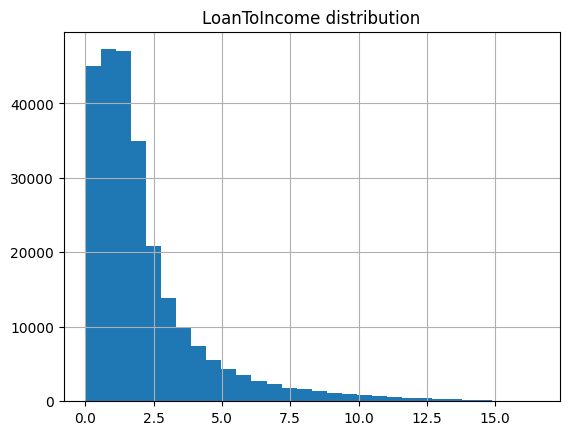

In [28]:
# 3. Feature engineering

df["LoanToIncome"] = df["LoanAmount"] / (df["Income"] + 1e-6)    # + 1e-6 to avoid dividing by 0

df["LoanToIncome"].describe()
df["LoanToIncome"].hist(bins=30)
plt.title("LoanToIncome distribution")
plt.show()



As a simple feature engineering step, we add LoanToIncome, a scale-invariant measure of loan burden.
This ratio complements variables like Income and LoanAmount by capturing their interaction in a single interpretable metric.
We use a small epsilon to prevent division-by-zero for rare edge cases. We visualize the distribution to check for skewness/outliers, which is typical for ratio-based variables.

In [29]:
# Numeric features update
numeric_features = [
    "Age", "Income", "LoanAmount", "CreditScore",
    "MonthsEmployed", "NumCreditLines",
    "InterestRate", "LoanTerm", "DTIRatio",
    "LoanToIncome"
]


We update the list of numeric features to include the engineered variable LoanToIncome.
This ensures the preprocessing pipeline applies numeric transformations (imputation + scaling) consistently to all continuous variables.

In [30]:
# train-test split


X = df.drop(columns=[target, "LoanID"])
y = df[target]

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


We split the data into train and test sets (80/20) and use stratify=y to preserve the class imbalance ratio in both subsets.
LoanID is removed because it is an identifier and carries no predictive signal.
random_state ensures reproducibility.

# Data Preprocessing: Missing Value Imputation and Feature Scaling

In [31]:
# Preprocessing (numeric + categorical)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Pipeline for numerical features: imputation + scaling
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline for categorical features: imputation + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine numeric and categorical transformations into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)



We build a unified preprocessing pipeline to handle mixed data types in a consistent and leak-free way.
Numerical features are imputed with the median (robust to outliers) and standardized to make scale-sensitive models (e.g., Logistic Regression, SVM) comparable.
Categorical features are imputed with the most frequent value and one-hot encoded; handle_unknown="ignore" prevents errors when unseen categories appear in the test set.
Wrapping preprocessing inside a Pipeline ensures all transformations are fitted only on the training data during cross-validation.


Scaling detail: because StandardScaler is inside the pipeline, its mean and standard deviation are learned only from the training fold/train set (fit), and then applied to validation/test data via transform only. This prevents accidentally using test-set statistics for scaling.

# Logistic Regression

In [34]:

# 4. Logistic Regression (L2 + CV)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    balanced_accuracy_score,
    precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, auc
)

RANDOM_STATE = 42




In [35]:
# 4.1 Pipeline + CV (GridSearch)

log_reg_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

param_grid_logreg = {"model__C": [0.01, 0.1, 1, 10]}

log_reg_grid = GridSearchCV(
    estimator=log_reg_pipe,
    param_grid=param_grid_logreg,
    scoring="average_precision",   # <-- PR
    cv=5,
    n_jobs=-1,
    verbose=1
)

log_reg_grid.fit(x_train, y_train)

best_log_reg = log_reg_grid.best_estimator_
print("Best params for Logistic Regression:", log_reg_grid.best_params_)
print("Best CV Average Precision (PR):", log_reg_grid.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params for Logistic Regression: {'model__C': 0.1}
Best CV Average Precision (PR): 0.3264049763175983


Logistic Regression is trained using a preprocessing–model pipeline and tuned via 5-fold cross-validation. Model hyperparameters are selected using 5-fold stratified cross-validation, ensuring that each fold preserves the proportion of default and non-default observations in the training data.

In credit default prediction, the primary objective is to identify as many defaulting borrowers as possible, making recall of the default class a key concern. Misclassifying a defaulter as a non-defaulter (false negative) is substantially more costly than incorrectly flagging a non-defaulter (false positive). Average Precision, a precision–recall (PR)–based metric, is therefore used as the cross-validation scoring criterion. It summarizes performance across the precision–recall curve and is particularly well suited for imbalanced loan default classification, as it emphasizes performance on the minority default class while avoiding trivial high-recall solutions.

In [ ]:
# 4.2 Test evaluation (default threshold = 0.5)

y_pred_logreg = best_log_reg.predict(x_test)                   # threshold=0.5
y_proba_logreg = best_log_reg.predict_proba(x_test)[:, 1]      # probabilities for ROC/PR

bacc = balanced_accuracy_score(y_test, y_pred_logreg)
prec = precision_score(y_test, y_pred_logreg, zero_division=0)
rec = recall_score(y_test, y_pred_logreg, zero_division=0)
f1 = f1_score(y_test, y_pred_logreg, zero_division=0)
f2 = fbeta_score(y_test, y_pred_logreg, beta=2, zero_division=0)

roc_auc = roc_auc_score(y_test, y_proba_logreg)
ap = average_precision_score(y_test, y_proba_logreg)  # PR score (Average Precision)

print("\nLogistic Regression (CV tuned on PR) – test performance (threshold=0.5)")
print(f"Balanced Acc: {bacc:.3f}")
print(f"Precision   : {prec:.3f}")
print(f"Recall      : {rec:.3f}")
print(f"F1-score    : {f1:.3f}")
print(f"F2-score    : {f2:.3f}")
print(f"Average Prec: {ap:.3f}")
print(f"ROC AUC     : {roc_auc:.3f}")

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

print("\nClassification report:")
print(classification_report(y_test, y_pred_logreg, zero_division=0))



Logistic Regression (CV tuned on PR) – test performance (threshold=0.5)
Balanced Acc: 0.693
Precision   : 0.228
Recall      : 0.697
F1-score    : 0.344
F2-score    : 0.494
Average Prec: 0.336
ROC AUC     : 0.762

Confusion matrix:
[[31152 13987]
 [ 1798  4133]]

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     45139
           1       0.23      0.70      0.34      5931

    accuracy                           0.69     51070
   macro avg       0.59      0.69      0.57     51070
weighted avg       0.86      0.69      0.75     51070



We report metrics on the held-out test set using the default threshold 0.5 to provide a consistent reference point (precision/recall trade-off + confusion matrix). With the default threshold (0.5), the model achieves relatively high recall for the minority class, but at the cost of low precision (many false positives). This is expected in imbalanced classification, especially with class_weight="balanced", and motivates later threshold tuning depending on the business cost of false negatives vs false positive


PR AUC (Average Precision): 0.336 (baseline=0.116)
F2 (threshold=0.5): 0.494
Balanced Acc (threshold=0.5): 0.693


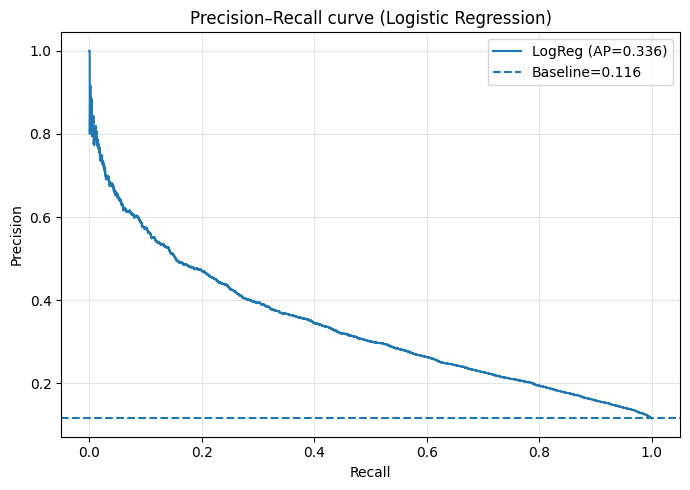

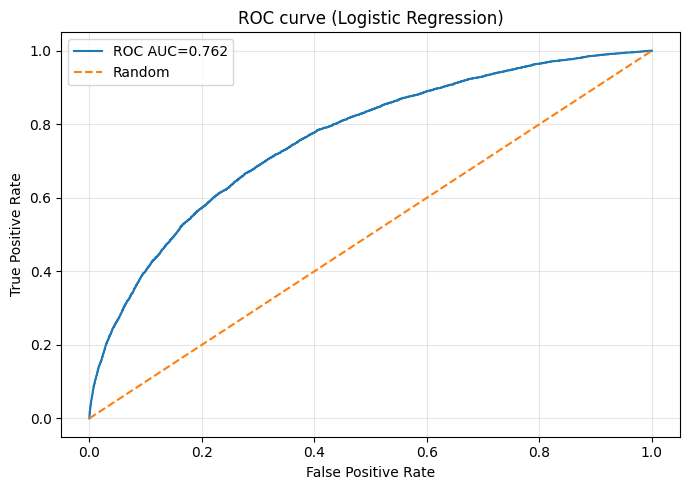

In [ ]:
# 4.3 PR AUC + PR/ROC curves

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    roc_curve, auc, fbeta_score, balanced_accuracy_score
)

plt.close("all")

# PR AUC (Average Precision)
pr_auc = average_precision_score(y_test, y_proba_logreg)
baseline = y_test.mean()
print(f"\nPR AUC (Average Precision): {pr_auc:.3f} (baseline={baseline:.3f})")

# Extra: classification metrics at default threshold=0.5 (for reference)
y_pred_05 = (y_proba_logreg >= 0.5).astype(int)
f2_05 = fbeta_score(y_test, y_pred_05, beta=2, zero_division=0)
bacc_05 = balanced_accuracy_score(y_test, y_pred_05)
print(f"F2 (threshold=0.5): {f2_05:.3f}")
print(f"Balanced Acc (threshold=0.5): {bacc_05:.3f}")

# PR curve
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba_logreg)

plt.figure(figsize=(7, 5))
plt.plot(rec_curve, prec_curve, label=f"LogReg (AP={pr_auc:.3f})")
plt.axhline(y=baseline, linestyle="--", label=f"Baseline={baseline:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (Logistic Regression)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_logreg)
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc_curve:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (Logistic Regression)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


We additionally plot PR and ROC curves to visualize performance across all thresholds. For imbalanced data, the PR curve / Average Precision is especially useful because it focuses on the minority class and is not dominated by true negatives.These plots also help us choose (and later tune) a decision threshold that matches our objective (e.g., higher recall / F2).

# Decision Tree

In [ ]:
# 5. Decision Tree

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    balanced_accuracy_score,
    precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

RANDOM_STATE = 42


Decision Tree is included as a simple non-linear model. We tune its main complexity parameters with 5-fold CV optimized for Average Precision.

In [ ]:
# 5.1. Pipeline
dt_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [ ]:
# 5.2. Small grid
param_grid_dt = {
    "model__max_depth": [None, 5, 10],
    "model__min_samples_leaf": [2, 5, 10],
    "model__class_weight": [None, "balanced"]
}

dt_grid = GridSearchCV(
    estimator=dt_pipe,
    param_grid=param_grid_dt,
    scoring="average_precision",   # <-- PR w CV
    cv=5,
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(x_train, y_train)

best_dt = dt_grid.best_estimator_
print("Best DT params:", dt_grid.best_params_)
print("Best CV Average Precision (PR):", dt_grid.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best DT params: {'model__class_weight': 'balanced', 'model__max_depth': 10, 'model__min_samples_leaf': 2}
Best CV Average Precision (PR): 0.2645177751888373


We tune tree complexity (max_depth, min_samples_leaf) and optionally use class_weight="balanced" to mitigate class imbalance. Model selection is based on 5-fold CV Average Precision.

In [ ]:
# 5.3. Test evaluation (threshold=0.5)
y_pred_dt = best_dt.predict(x_test)
y_proba_dt = best_dt.predict_proba(x_test)[:, 1]

bacc = balanced_accuracy_score(y_test, y_pred_dt)
prec = precision_score(y_test, y_pred_dt, zero_division=0)
rec = recall_score(y_test, y_pred_dt, zero_division=0)
f1 = f1_score(y_test, y_pred_dt, zero_division=0)
f2 = fbeta_score(y_test, y_pred_dt, beta=2, zero_division=0)

ap = average_precision_score(y_test, y_proba_dt)  # PR score
roc_auc = roc_auc_score(y_test, y_proba_dt)

print("\nDecision Tree – test performance (CV tuned on PR, threshold=0.5)")
print(f"Balanced Acc: {bacc:.3f}")
print(f"Precision   : {prec:.3f}")
print(f"Recall      : {rec:.3f}")
print(f"F1-score    : {f1:.3f}")
print(f"F2-score    : {f2:.3f}")
print(f"Average Prec: {ap:.3f}")
print(f"ROC AUC     : {roc_auc:.3f}")

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_dt))



Decision Tree – test performance (CV tuned on PR, threshold=0.5)
Balanced Acc: 0.660
Precision   : 0.207
Recall      : 0.646
F1-score    : 0.313
F2-score    : 0.453
Average Prec: 0.277
ROC AUC     : 0.710

Confusion matrix:
[[30422 14717]
 [ 2100  3831]]



Decision Tree — PR AUC (Average Precision): 0.277 (baseline=0.116)


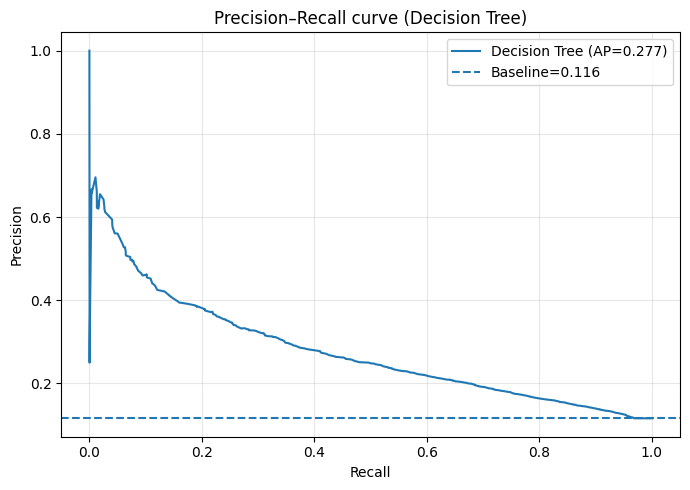

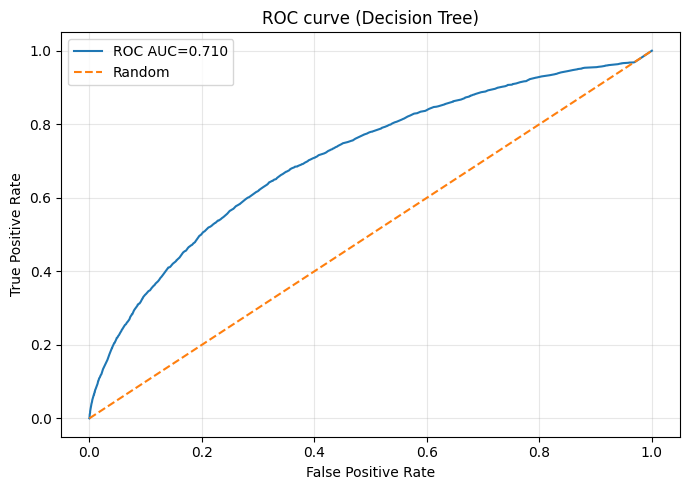

In [ ]:
# 5.4 PR & ROC curves for DT

plt.close("all")

# PR AUC (Average Precision)
ap_dt = average_precision_score(y_test, y_proba_dt)
baseline = y_test.mean()
print(f"\nDecision Tree — PR AUC (Average Precision): {ap_dt:.3f} (baseline={baseline:.3f})")

# PR curve
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba_dt)

plt.figure(figsize=(7, 5))
plt.plot(rec_curve, prec_curve, label=f"Decision Tree (AP={ap_dt:.3f})")
plt.axhline(y=baseline, linestyle="--", label=f"Baseline={baseline:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (Decision Tree)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc_curve:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (Decision Tree)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Random Forest

In [ ]:
# 6. Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import (
    balanced_accuracy_score,
    precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

RANDOM_STATE = 42


In [ ]:
# 6.1 Pipeline
rf_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1
    ))
])




In [ ]:
# 6.2 Tiny random search
param_dist_rf = {
    "model__n_estimators": randint(100, 200),
    "model__max_depth": [None, 10, 16],
    "model__min_samples_leaf": randint(2, 6),
    "model__max_features": ["sqrt", 0.5]
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist_rf,
    n_iter=5,          # fewer attempts = faster
    scoring="average_precision",   # <-- PR w CV
    cv=5,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

rf_search.fit(x_train, y_train)

best_rf = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)
print("Best CV Average Precision (PR):", rf_search.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'model__max_depth': 16, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__n_estimators': 199}
Best CV Average Precision (PR): 0.31096377548118903


In [ ]:
   # 6.3 Test evaluation (threshold=0.5)
y_pred_rf  = best_rf.predict(x_test)
y_proba_rf = best_rf.predict_proba(x_test)[:, 1]

bacc = balanced_accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf, zero_division=0)
rec  = recall_score(y_test, y_pred_rf, zero_division=0)
f1   = f1_score(y_test, y_pred_rf, zero_division=0)
f2   = fbeta_score(y_test, y_pred_rf, beta=2, zero_division=0)

ap     = average_precision_score(y_test, y_proba_rf)  # PR score
roc_auc = roc_auc_score(y_test, y_proba_rf)

print("\nRandom Forest – test performance (CV tuned on PR, threshold=0.5)")
print(f"Balanced Acc: {bacc:.3f}")
print(f"Precision   : {prec:.3f}")
print(f"Recall      : {rec:.3f}")
print(f"F1-score    : {f1:.3f}")
print(f"F2-score    : {f2:.3f}")
print(f"Average Prec: {ap:.3f}")
print(f"ROC AUC     : {roc_auc:.3f}")

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))



Random Forest – test performance (CV tuned on PR, threshold=0.5)
Balanced Acc: 0.630
Precision   : 0.346
Recall      : 0.347
F1-score    : 0.346
F2-score    : 0.347
Average Prec: 0.320
ROC AUC     : 0.755

Confusion matrix:
[[41254  3885]
 [ 3875  2056]]

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     45139
           1       0.35      0.35      0.35      5931

    accuracy                           0.85     51070
   macro avg       0.63      0.63      0.63     51070
weighted avg       0.85      0.85      0.85     51070




Random Forest — PR AUC (Average Precision): 0.320 (baseline=0.116)


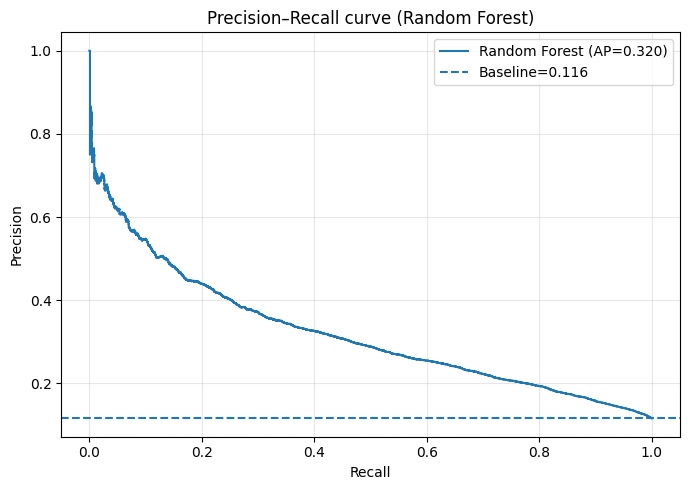

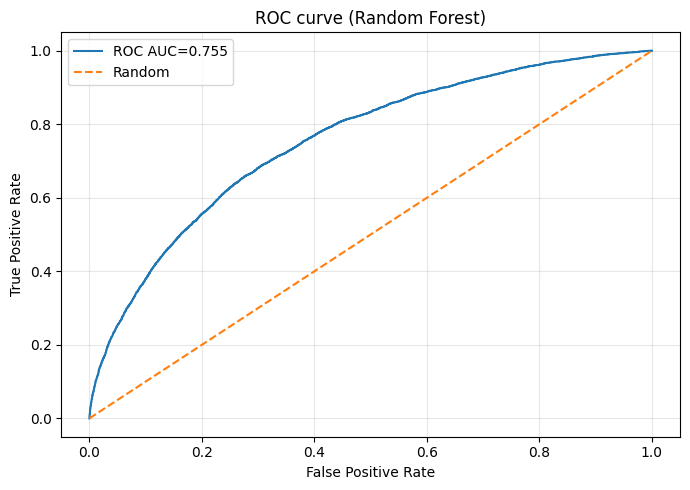

In [ ]:
# 6.4 PR & ROC curves for RF

plt.close("all")

# PR AUC (Average Precision)
ap_rf = average_precision_score(y_test, y_proba_rf)
baseline = y_test.mean()
print(f"\nRandom Forest — PR AUC (Average Precision): {ap_rf:.3f} (baseline={baseline:.3f})")

# PR curve
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(7, 5))
plt.plot(rec_curve, prec_curve, label=f"Random Forest (AP={ap_rf:.3f})")
plt.axhline(y=baseline, linestyle="--", label=f"Baseline={baseline:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (Random Forest)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc_curve:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (Random Forest)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Support Vector Machine

In [ ]:
# 7. SVM (LinearSVC)

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    balanced_accuracy_score,
    precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

RANDOM_STATE = 42


In [ ]:
# 7.1 Pipeline
svm_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearSVC(
        class_weight="balanced",
        max_iter=5000,
        random_state=RANDOM_STATE
    ))
])

In [ ]:
# 7.2 Small grid
param_grid_svm = {
    "model__C": [0.01, 0.1, 1, 10]
}

svm_grid = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid_svm,
    scoring="average_precision",   # <-- PR w CV
    cv=5,
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(x_train, y_train)

best_svm = svm_grid.best_estimator_
print("Best SVM params:", svm_grid.best_params_)
print("Best CV Average Precision (PR):", svm_grid.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best SVM params: {'model__C': 1}
Best CV Average Precision (PR): 0.32634112844626145


In [ ]:
# 7.3 Test evaluation (threshold implied by predict())
y_pred_svm = best_svm.predict(x_test)

# LinearSVC doesn't have predict_proba -> use decision_function for ROC/PR
y_score_svm = best_svm.decision_function(x_test)

bacc = balanced_accuracy_score(y_test, y_pred_svm)
prec = precision_score(y_test, y_pred_svm, zero_division=0)
rec  = recall_score(y_test, y_pred_svm, zero_division=0)
f1   = f1_score(y_test, y_pred_svm, zero_division=0)
f2   = fbeta_score(y_test, y_pred_svm, beta=2, zero_division=0)

ap = average_precision_score(y_test, y_score_svm)   # PR score from scores
roc_auc = roc_auc_score(y_test, y_score_svm)

print("\nSVM (LinearSVC) – test performance (CV tuned on PR)")
print(f"Balanced Acc: {bacc:.3f}")
print(f"Precision   : {prec:.3f}")
print(f"Recall      : {rec:.3f}")
print(f"F1-score    : {f1:.3f}")
print(f"F2-score    : {f2:.3f}")
print(f"Average Prec: {ap:.3f}")
print(f"ROC AUC     : {roc_auc:.3f}")

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_svm))



SVM (LinearSVC) – test performance (CV tuned on PR)
Balanced Acc: 0.694
Precision   : 0.228
Recall      : 0.699
F1-score    : 0.343
F2-score    : 0.494
Average Prec: 0.336
ROC AUC     : 0.762

Confusion matrix:
[[31085 14054]
 [ 1788  4143]]



Linear SVM — PR AUC (Average Precision): 0.336 (baseline=0.116)


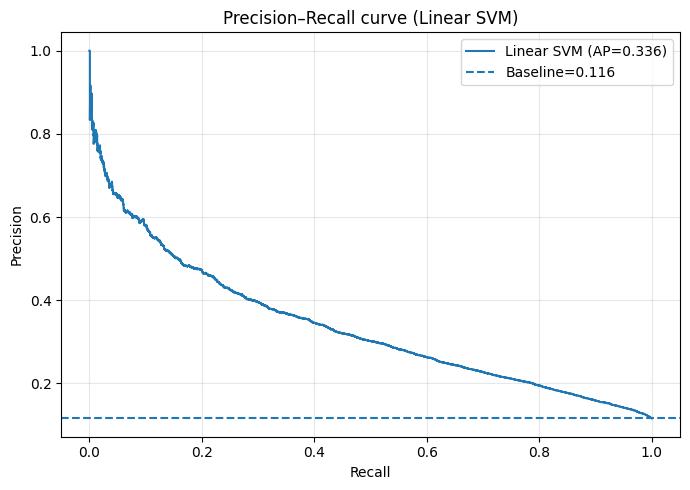

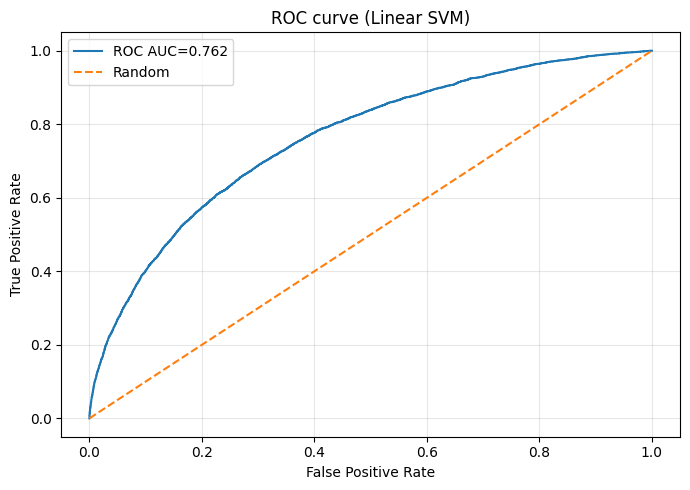

In [ ]:
# 7.4 PR & ROC curves for Linear SVM

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

plt.close("all")

# PR AUC (Average Precision) from decision scores
ap_svm = average_precision_score(y_test, y_score_svm)
baseline = y_test.mean()
print(f"\nLinear SVM — PR AUC (Average Precision): {ap_svm:.3f} (baseline={baseline:.3f})")

# PR curve
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_score_svm)

plt.figure(figsize=(7, 5))
plt.plot(rec_curve, prec_curve, label=f"Linear SVM (AP={ap_svm:.3f})")
plt.axhline(y=baseline, linestyle="--", label=f"Baseline={baseline:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (Linear SVM)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score_svm)
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc_curve:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (Linear SVM)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Comparison of models' results

In [ ]:
# Models results


def results(name, y_true, y_pred, y_score):
    """y_score = proba[:,1] OR decision_function scores"""
    return {
        "Model": name,
        "CV": "5-fold",
        "Balanced Acc": balanced_accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "F2": fbeta_score(y_true, y_pred, beta=2, zero_division=0),
        "Average Prec": average_precision_score(y_true, y_score),
        "ROC AUC": roc_auc_score(y_true, y_score),
    }

rows = []
rows.append(results("Logistic Regression", y_test, y_pred_logreg, y_proba_logreg))
rows.append(results("Decision Tree", y_test, y_pred_dt, y_proba_dt))
rows.append(results("Random Forest", y_test, y_pred_rf, y_proba_rf))
rows.append(results("Linear SVM", y_test, y_pred_svm, y_score_svm))

results = pd.DataFrame(rows).sort_values(["F2", "Average Prec"], ascending=False).reset_index(drop=True)
results.index = np.arange(1, len(results) + 1)
results

,Model,CV,Balanced Acc,Precision,Recall,F1,F2,Average Prec,ROC AUC
1,Linear SVM,5-fold,0.693592,0.227675,0.698533,0.343418,0.494144,0.336393,0.761624
2,Logistic Regression,5-fold,0.693491,0.228091,0.696847,0.343686,0.493858,0.336250,0.761595
3,Decision Tree,5-fold,0.659945,0.206545,0.645928,0.313003,0.453137,0.276571,0.709662
4,Random Forest,5-fold,0.630293,0.346070,0.346653,0.346361,0.346536,0.320281,0.755104


Final model choice: Logistic Regression
Logistic Regression and Linear SVM achieved the same top performance on our key metrics (F2 = 0.494 and Average Precision = 0.336). We selected Logistic Regression as the final model because it is simpler and more interpretable (clear feature coefficients), easier to communicate and deploy, and provides stable, well-calibrated probability outputs that are useful for threshold tuning on imbalanced data. Therefore, LR is used as the final baseline for feature selection and final threshold optimization.

# Feature selection for final model (Logistic Regression)

Having identified Logistic Regression as the preferred baseline model, we proceed with embedded feature selection and decision threshold optimization to further improve recall-focused performance while maintaining interpretability.

We apply feature selection only for the final chosen model to keep the earlier model comparison fair (all models trained on the same feature space).
Instead of variance-based filtering (which can arbitrarily drop individual one-hot encoded levels), we use Logistic Regression with Elastic Net regularization, which provides an embedded feature selection mechanism (some coefficients shrink to zero).
We tune C and l1_ratio via cross-validation using average_precision, and then tune the decision threshold on the training set to maximize F2.

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TunedThresholdClassifierCV

from sklearn.metrics import (
    make_scorer, fbeta_score,
    balanced_accuracy_score, average_precision_score,
    ConfusionMatrixDisplay
)


For the final model we use Logistic Regression with Elastic Net (embedded feature selection).
We tune C and l1_ratio with CV using Average Precision, then tune the decision threshold (CV, optimized for F2) and report final test metrics + confusion matrix.

In [36]:
# Logistic Regression with Elastic Net (embedded feature selection)
log_reg_en_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        max_iter=5000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

print(log_reg_en_pipe)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Income',
                                                   'LoanAmount', 'CreditScore',
                                                   'MonthsEmployed',
                                                   'NumCreditLines',
                                                   'InterestRate', 'LoanTerm',
                                                   'DTIRatio',
                                                   'LoanToIncome']),
                                                 ('cat',
           

In [ ]:
# Hyperparameter tuning for Elastic Net Logistic Regression:
# We tune C and l1_ratio using CV with scoring='average_precision' (Average Precision),
# which is suitable for imbalanced data and focuses on minority-class ranking quality.

param_grid_en = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__l1_ratio": [0.1, 0.5, 0.9]
}

lr_en_grid = GridSearchCV(
    estimator=log_reg_en_pipe,
    param_grid=param_grid_en,
    scoring="average_precision",   # PR in CV
    cv=5,
    n_jobs=-1,
    verbose=1
)

lr_en_grid.fit(x_train, y_train)

best_lr_en = lr_en_grid.best_estimator_

print("Best params (Elastic Net LR):", lr_en_grid.best_params_)
print("Best CV Average Precision (PR):", lr_en_grid.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params (Elastic Net LR): {'model__C': 0.01, 'model__l1_ratio': 0.1}
Best CV Average Precision (PR): 0.32640674101077854


# Treshold tuning

The default decision threshold (commonly 0.5 for probabilistic classifiers) is often not optimal for imbalanced data.
 We tune the decision threshold using cross-validation on the training set to maximize F2 (beta=2), because F2 prioritizes recall more than precision.

Tuned threshold (CV, optimized for F2): 0.46100555367516993

Final Elastic Net LR + tuned threshold — TEST performance
Balanced Acc: 0.690
Recall      : 0.750
Precision   : 0.211
F2-score    : 0.496
Average Prec: 0.336


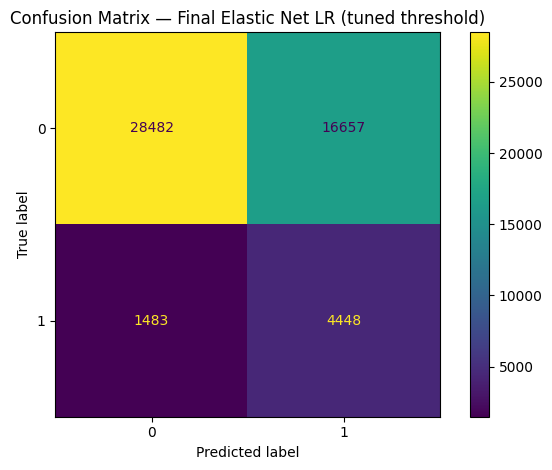

In [ ]:


f2_scorer = make_scorer(fbeta_score, beta=2, zero_division=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

lr_thr_en = TunedThresholdClassifierCV(
    estimator=best_lr_en,     #  Elastic Net LR
    scoring=f2_scorer,
    cv=cv
)

lr_thr_en.fit(x_train, y_train)

print("Tuned threshold (CV, optimized for F2):", lr_thr_en.best_threshold_)

# Final evaluation on the held-out test set:
# We report Balanced Accuracy (robust to class imbalance), F2-score (final selection metric),
# and Average Precision (PR-AUC) based on predicted probabilities.

y_pred_tuned = lr_thr_en.predict(x_test)
y_proba_test = lr_thr_en.predict_proba(x_test)[:, 1]

bacc = balanced_accuracy_score(y_test, y_pred_tuned)
f2 = fbeta_score(y_test, y_pred_tuned, beta=2, zero_division=0)
ap = average_precision_score(y_test, y_proba_test)
rec = recall_score(y_test, y_pred_tuned, zero_division=0)
prec = precision_score(y_test, y_pred_tuned, zero_division=0)

print("\nFinal Elastic Net LR + tuned threshold — TEST performance")
print(f"Balanced Acc: {bacc:.3f}")
print(f"Recall      : {rec:.3f}")
print(f"Precision   : {prec:.3f}")
print(f"F2-score    : {f2:.3f}")
print(f"Average Prec: {ap:.3f}")

# Confusion matrix visualization:
# This shows the trade-off introduced by the tuned threshold: typically fewer false negatives (higher recall)
# at the cost of more false positives.

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned, values_format="d")
plt.title("Confusion Matrix — Final Elastic Net LR (tuned threshold)")
plt.tight_layout()
plt.show()


The final Elastic Net Logistic Regression model with a tuned decision threshold achieves an F2-score of 0.496 and an Average Precision of 0.336 on the test set and confirming its effectiveness in identifying defaulting borrowers while maintaining reasonable overall discrimination.

# Conclusion

This project evaluated several supervised classification models to predict loan default, with a **primary focus on minimizing false negatives due to their high economic cost in credit risk management**. Model performance was assessed using PR AUC during cross-validation and the F2-score on held-out test data to prioritize recall for defaulting borrowers.

Among the evaluated models, **Elastic Net Logistic Regression** was selected as the final model due to its strong recall performance, interpretability, and suitability for financial applications. After optimizing the decision threshold for the F2-score, the **model achieved a recall of 0.75 for defaulters** on the test set, indicating effective identification of high-risk borrowers. This improvement came at the cost of lower precision, reflecting an intentional trade-off toward reducing costly false negatives. A balanced accuracy of 0.69 suggests reasonable overall discrimination despite class imbalance.

Overall, the **results confirm that regularized logistic regression combined with threshold tuning remains a robust and practical approach for credit default prediction**, offering competitive performance while maintaining transparency and flexibility in risk management.

# Limitations

The analysis is based on a static public dataset and does not capture temporal dynamics or changing economic conditions. Misclassification costs are addressed indirectly through metric selection and threshold tuning rather than explicit cost-sensitive learning. In addition, evaluation relies on a single train–test split without external validation, which may limit generalizability. Future work could incorporate time-based validation, explicit cost modeling, and richer feature sets to further improve predictive performance.